In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import os
import plotly.express as px
import plotly.subplots as ps
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from keras.utils import to_categorical, plot_model

In [23]:
train_data = pd.read_csv('/Users/abdihussein/Downloads/train.csv', sep = ',')
test_data = pd.read_csv('/Users/abdihussein/Downloads/test.csv', sep = ',')
#pd.set_option( "display.max_columns", None)

#pd.read_csv('/Users/abdihussein/Downloads/playground-series-s3e22/train.csv', sep=',',header=None)



In [3]:
train_data = train_data[train_data.columns[1:]] # Remove id in Data table
test_data = test_data[test_data.columns[1:]] # Remove id in Data table

In [4]:
numeric_train = train_data.select_dtypes(include=['float'])
Classify_train = train_data.select_dtypes(exclude = ['float'])

numeric_test = test_data.select_dtypes(include =('float'))
Classify_test = test_data.select_dtypes(exclude = ['float'])

In [5]:
Classify_train [Classify_train .columns[1:]].nunique()

age                        2
hospital_number          255
temp_of_extremities        5
peripheral_pulse           5
mucous_membrane            7
capillary_refill_time      4
pain                       7
peristalsis                6
abdominal_distention       5
nasogastric_tube           4
nasogastric_reflux         5
rectal_exam_feces          6
abdomen                    6
abdomo_appearance          4
surgical_lesion            2
lesion_1                  57
lesion_2                   4
lesion_3                   2
cp_data                    2
outcome                    3
dtype: int64

In [6]:
Classify_train = Classify_train.drop("hospital_number",axis = 1)
Classify_test = Classify_test.drop("hospital_number",axis = 1)

In [7]:
Classify_train = Classify_train.fillna("unknown")
Classify_test = Classify_test.fillna("unknown")

In [8]:
Classify_train['Count'] = 1
Classify_train_dpone = Classify_train.drop('lesion_1',axis = 1)
Analysis_class = pd.get_dummies(Classify_train_dpone, columns = ['outcome'])
Analysis_class = Analysis_class.rename(columns = {'outcome_died' : 'died', 'outcome_euthanized' : 'euthanized', 'outcome_lived' : 'lived'})

dict_outcome = {True : 1, False : 0 }
for col in Analysis_class.columns[-3:]:
    Analysis_class[col] = Analysis_class[col].replace(dict_outcome)

In [9]:
def plot_stack_bar(col):
    col_gp =Analysis_class.groupby(col).sum()
    col_gp['dead_rate'] = col_gp['died'] / col_gp['Count']
    col_gp['euthanized_rate'] = col_gp['euthanized'] / col_gp['Count']
    col_gp['lived_rate'] = col_gp['lived'] / col_gp['Count']
    fig_1 = px.bar(col_gp, x=col_gp.index, y=['dead_rate','euthanized_rate','lived_rate'], title=f"The {col} of stack bar in Percent",width=400, height=600)
    fig_2 = px.bar(col_gp, x=col_gp.index, y=['died','euthanized','lived'], labels={'value':'Count'}, title=f"The {col} of stack bar in Count",width=400, height=600)
    fig = ps.make_subplots(rows=1, cols=2,subplot_titles=(f'The {col} of outcome in Percent',f'The {col} of outcome in Count'))
    for i in range(3):
        fig.add_trace(fig_1.data[i], row=1, col=1)
        fig.add_trace(fig_2.data[i], row=1, col=2)
    fig.show()
    return fig

In [10]:
numeric_ot_train = pd.concat([numeric_train, Analysis_class[Analysis_class.columns[-4:]]],axis = 1)
numeric_ot_train

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,Count,died,euthanized,lived
0,38.1,132.0,24.0,6.5,57.0,8.5,3.4,1,1,0,0
1,37.5,88.0,12.0,2.0,33.0,64.0,2.0,1,0,1,0
2,38.3,120.0,28.0,3.5,37.0,6.4,3.4,1,0,0,1
3,37.1,72.0,30.0,2.0,53.0,7.0,3.9,1,0,0,1
4,38.0,52.0,48.0,7.0,47.0,7.3,2.6,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1230,38.5,129.0,48.0,2.0,57.0,66.0,2.0,1,0,0,1
1231,37.5,60.0,50.0,3.0,35.0,6.4,3.6,1,1,0,0
1232,37.5,84.0,40.0,3.0,40.0,5.9,7.0,1,0,0,1
1233,38.1,70.0,16.0,2.0,58.0,74.0,2.0,1,0,0,1


In [11]:
def numeric_plot(col):
    fig_name = col
    fig_name, axes = plt.subplots(1,1, figsize=(5,5))
    sns.distplot(numeric_ot_train[numeric_ot_train['died'] == 1][col], norm_hist = True, color = 'r', label = 'Die')
    sns.distplot(numeric_ot_train[numeric_ot_train['euthanized'] == 1][col],  norm_hist = True, color = 'y', label = 'Euthanized')
    sns.distplot(numeric_ot_train[numeric_ot_train['lived'] == 1][col], norm_hist = True, color = 'g', label = 'Lived')
    axes.set_title(f'The Distribution of {col} with Outcome ')
    axes.legend()
    return fig_name

In [12]:
Classify_train_data = Classify_train.drop(columns = ['Count','outcome'])
Classify_test_data = Classify_test
target_outcome = Classify_train['outcome']

In [13]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
Normal_target = LabelEncoder()
target= Normal_target.fit_transform(target_outcome)

Class_enc = OneHotEncoder(handle_unknown = 'ignore')
C_train_data = Class_enc.fit_transform(Classify_train_data).toarray()
C_test_data = Class_enc.transform(Classify_test_data).toarray() 
print(f'The Classify train data shape : {C_train_data .shape}')
print(f'The Classify test data shape : {C_test_data .shape}')

The Classify train data shape : (1235, 135)
The Classify test data shape : (824, 135)


In [14]:
N_train_data = numeric_train.to_numpy()
N_test_data = numeric_test.to_numpy()
print(f'The Numeric train data shape : {N_train_data.shape}')
print(f'The Numeric test data shape : {N_test_data.shape}')

The Numeric train data shape : (1235, 7)
The Numeric test data shape : (824, 7)


In [15]:
CN_train_data = np.concatenate([C_train_data,N_train_data], axis = 1)
CN_test_data = np.concatenate([C_test_data, N_test_data], axis = 1)
print(f' The Classify + Numeric train data of shape : {CN_train_data.shape}')
print(f' The Classify + Numeric test data of shape : {CN_test_data.shape}')

 The Classify + Numeric train data of shape : (1235, 142)
 The Classify + Numeric test data of shape : (824, 142)


In [16]:
from sklearn.model_selection import train_test_split

#fOR Classify
x_trainC, x_testC, y_trainC, y_testC = train_test_split(C_train_data, target, train_size = 0.8, random_state = 0)

y_trainC = to_categorical(y_trainC)

#For Numeric
x_trainN, x_testN, y_trainN, y_testN = train_test_split(N_train_data, target, train_size = 0.8, random_state = 0)

y_trainN = to_categorical(y_trainN)

In [17]:
import keras
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten
from keras.models import Model

C_input = keras.Input(shape=(C_train_data.shape[1],))
N_input = keras.Input(shape = (N_train_data.shape[1],))

#Classify model
C_hidden_1 = Dense(256,activation = 'relu')(C_input)
C_hidden_2 = Dense(64,activation = "relu")(C_hidden_1)
C_hidden_3 = Dense(16,activation = "relu")(C_hidden_2)

#Numeric model
N_hidden_1 = Dense(32,activation = 'relu')(N_input)
N_hidden_2 = Dense(16, activation = 'relu')(N_hidden_1)

#Concate
CN_layer = Concatenate()([C_hidden_3,N_hidden_2])

#Hidden layer for CN
CN_layer_2 = Dense(8, activation = 'relu')(CN_layer)

#Output layer
CN_output = Dense(3,activation = 'softmax')(CN_layer_2)

#Final model
model = Model(inputs = [C_input, N_input], outputs = CN_output)

#Compile and FIT
model.compile(optimizer= 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
history = model.fit([x_trainC,x_trainN], y_trainC, epochs = 50, validation_split = 0.2, batch_size = 256, verbose = 1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.2460 - loss: 4.7955 - val_accuracy: 0.2778 - val_loss: 2.6602
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2757 - loss: 2.6775 - val_accuracy: 0.3434 - val_loss: 2.3752
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3141 - loss: 2.6199 - val_accuracy: 0.3283 - val_loss: 2.0300
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3424 - loss: 2.1445 - val_accuracy: 0.3232 - val_loss: 1.7855
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3716 - loss: 1.8661 - val_accuracy: 0.3182 - val_loss: 1.6550
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4038 - loss: 1.6154 - val_accuracy: 0.3889 - val_loss: 1.4510
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4555 - loss: 1.3841 - val_accuracy: 0.4646 - val_loss: 1.2389
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5175 - loss: 1.2133 - val_accuracy: 0.5051 - val_loss: 1.1311

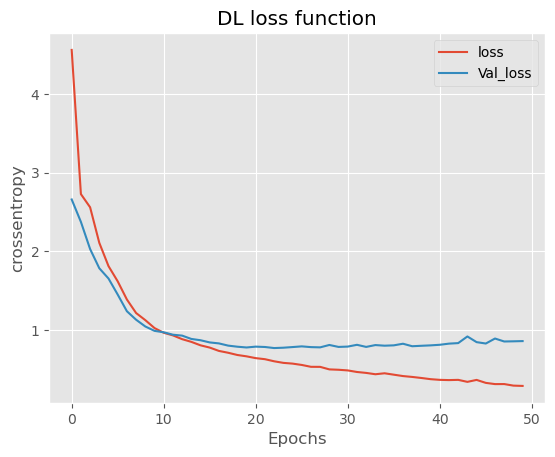

In [18]:
df_DL = pd.DataFrame(history.history)
df_DL.head()
plt.plot(df_DL.index, df_DL['loss'], label = 'loss')
plt.plot(df_DL.index, df_DL['val_loss'], label = 'Val_loss')
plt.xlabel( 'Epochs')
plt.ylabel('crossentropy')
plt.title('DL loss function')
plt.legend()

In [19]:
y_pred = model.predict([x_testC,x_testN])
y_pred = np.argmax(y_pred, axis = 1) # Inverse to_categorical
target_names = [x for x in list(Normal_target.classes_)]
print(classification_report(y_testC, y_pred , target_names = target_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
              precision    recall  f1-score   support

        died       0.70      0.78      0.73        89
  euthanized       0.57      0.55      0.56        42
       lived       0.80      0.74      0.77       116

    accuracy                           0.72       247
   macro avg       0.69      0.69      0.69       247
weighted avg       0.72      0.72      0.72       247



In [20]:
x_train, x_test, y_train, y_test = train_test_split(CN_train_data, target, train_size = 0.8, random_state = 0)

In [ ]:
ETC = ExtraTreesClassifier(n_estimators = 1200, n_jobs=-1).fit(x_train, y_train)
print('The Score for validation on ExtraTreesClassifier :', ETC.score(x_test, y_test))
y_pred = ETC.predict(x_test)
target_names = [x for x in list(Normal_target.classes_)]
print(classification_report(y_test, y_pred , target_names = target_names))

In [ ]:
prediction = XG.predict(CN_test_data)
submission = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission.csv')
submission["outcome"] = Normal_target.inverse_transform(prediction)
submission.to_csv('submission.csv', index=False)